In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import (DateFormatter, DayLocator, drange)
import requests
import re
import os
import time
import datetime
from scipy.interpolate import pchip
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm
import math

In [2]:
petition_url = "https://petition.president.gov.ua/petition/93004"

In [3]:
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) '\
        'Chrome/35.0.1916.47 Safari/537.36'
headers = {'User-Agent': user_agent}
try:
    request = requests.get(petition_url, headers=headers, timeout=None)
except requests.exceptions.RequestException as e:  # This is the correct syntax
    print("RequestException {} on page {}, {} signers".format(e, page_index, len(signers)))
request.encoding = 'utf-8'
html = request.text
regex = "<div class=\"pet_number\">(.*?)<\/div>.*?<h1>(.*?)<\/h1>.*?"\
    "<div class=\"pet_date\"><i class=\"fa fa-plus\"><\/i>Дата оприлюднення: (.*?)<\/div>"
data = re.findall(regex, html, re.MULTILINE | re.DOTALL)[0]
pet_number = data[0]
pet_title = data[1]
pet_date = data[2]
print("Петиція {} \"{}\" зареєстрована {}".format(pet_number, pet_title, pet_date))

Петиція №22/093004-еп "Про відкликання законопроекту №3316" зареєстрована 15 квітня 2020


In [4]:
url = "{}/votes/{}/json".format(petition_url, 1)
try:
    request = requests.get(url, headers=headers, timeout=None)
except requests.exceptions.RequestException as e:  # This is the correct syntax
    print("RequestException {} on page {}, {} signers".format(e, page_index, len(signers)))
request.encoding = 'utf-8'

json = request.json()
pag_html = json["pag_html"]
if("get_voters_page('2')" in pag_html):
    regex = "\\\">(\d*)</a></li><li class=\\\"pag_child\\\"><a href=\\\"#\\\" onclick=\\\"get_voters_page\('2'\);"
    data = re.findall(regex, pag_html, re.MULTILINE | re.DOTALL)[0]
    signers_pages_count = int(data)
else:
    signers_pages_count = 1
print("Підписанти: {} сторінок по 30 = ~{} підписів".format(signers_pages_count, signers_pages_count*30))

Підписанти: 563 сторінок по 30 = ~16890 підписів


In [5]:
signers = []
for page_index in tqdm(range(signers_pages_count)):
    time.sleep(1)
    url = "{}/votes/{}/json".format(petition_url, page_index+1)
    try:
        request = requests.get(url, headers=headers, timeout=None)
    except requests.exceptions.RequestException as e:  # This is the correct syntax
        print("RequestException {} on page {}, {} signers".format(e, page_index, len(signers)))
    request.encoding = 'utf-8'
    
    html = request.text
    if u'<h1>404. Такої сторінки не існує</h1>' in html:
        print("Crawling stopped on the page {}, {} signers with response status code 404".format(page_index,len(signers)))
        break

    json = request.json()
    table_html = json["table_html"]
    regex = "<div class=\"table_cell name\">(.*?)<\/div>.*?<div class=\"table_cell date\">(.*?)<\/div>"
    signers.extend(re.findall(regex, table_html, re.MULTILINE | re.DOTALL))

In [6]:
# Helper function for parsing the Ukrainian dates in format {day} {month name} {year}

ukr_month = ["січня", "лютого", "березня", "квітня", "травня", "червня", 
             "липня", "серпня", "вересня", "жовтня", "листопада", "грудня"]
test_date_str = "28 травня 2019"
def parse_ukr_date(date_str):
    date_str_formatted = date_str
    for month in ukr_month:
        if month in date_str:
            date_str_formatted = date_str.replace(" {} ".format(month), "-{:02d}-".format(ukr_month.index(month)+1))
            break
    date_time_obj = datetime.datetime.strptime(date_str_formatted, '%d-%m-%Y')
    return date_time_obj.date()

parse_ukr_date(test_date_str)

datetime.date(2019, 5, 28)

In [7]:
df = pd.DataFrame(signers, columns =['Name', 'Date'])
df.Date = df.Date.apply(lambda x : parse_ukr_date(x))

# Group sign count by day
# https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
df_grouped  = df.groupby(['Date'], as_index=False).agg({"Name": "count"})
df_grouped.rename(columns={'Name':'Count'}, inplace=True)

# Fill date gaps where no signs where registered
# https://skipperkongen.dk/2018/11/26/how-to-fill-missing-dates-in-pandas/
r = pd.date_range(start=df_grouped.Date.min(), end=df_grouped.Date.max())
df_grouped = df_grouped.set_index('Date').reindex(r).fillna(0).rename_axis('Date').reset_index()
df_grouped.Count = df_grouped.Count.astype(int)

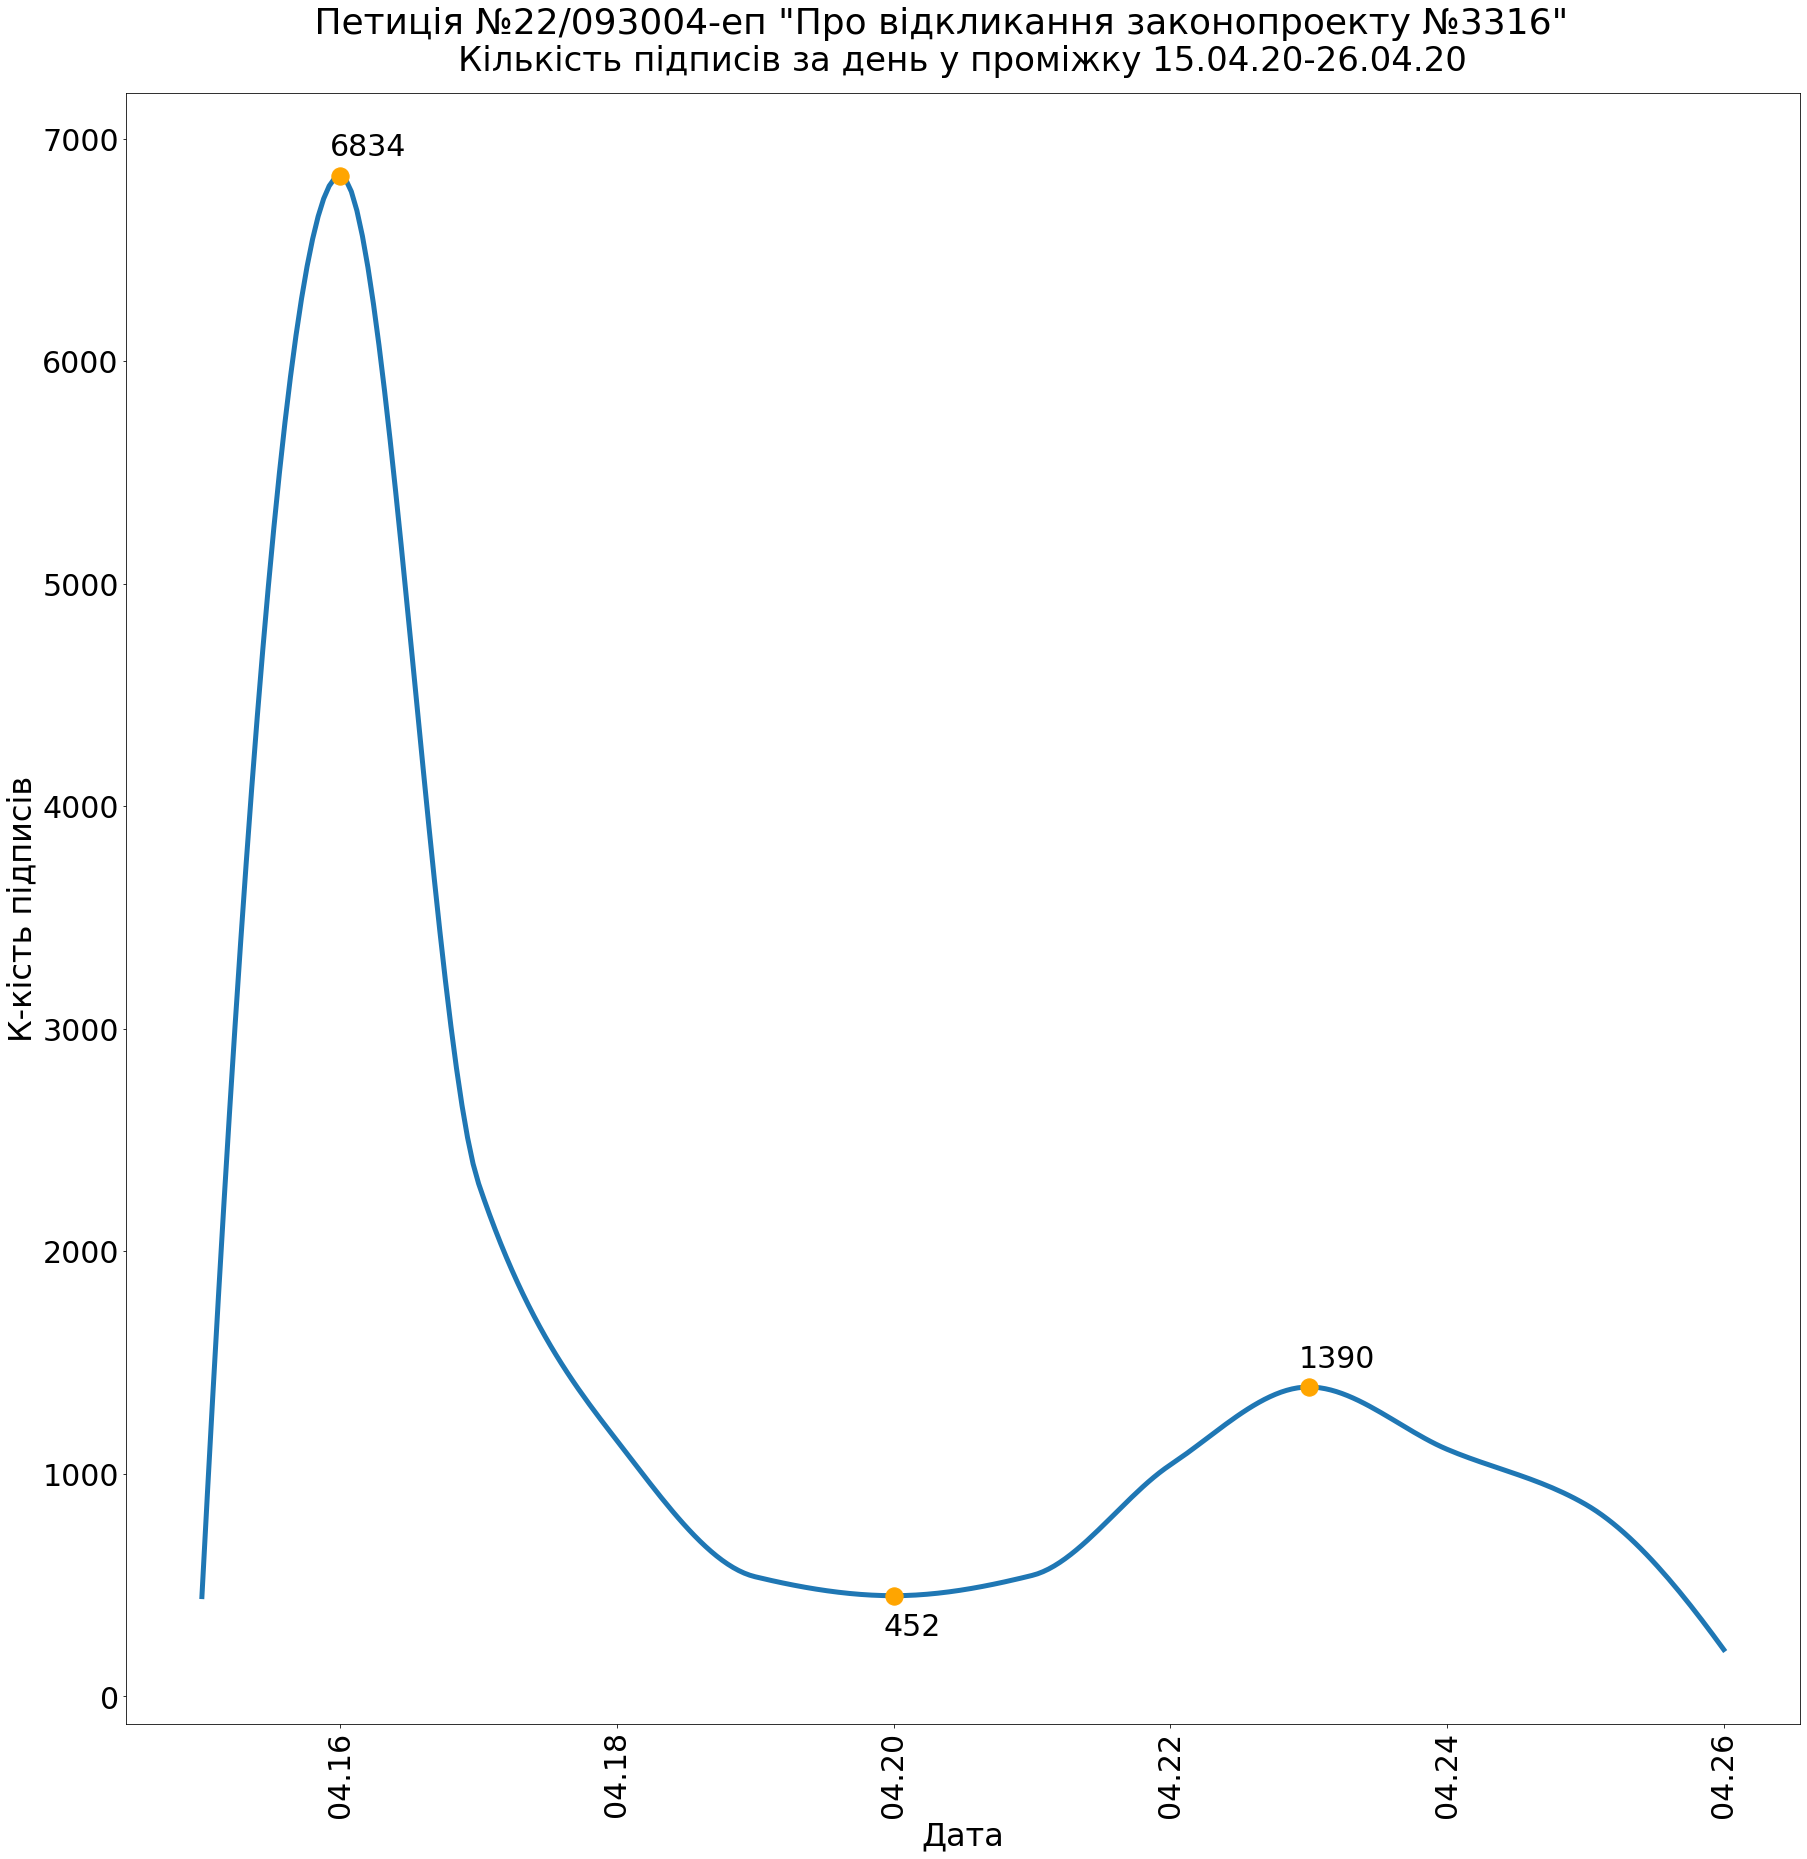

In [8]:
dates = matplotlib.dates.date2num(df_grouped.Date)
plt.rcParams['figure.figsize'] = [30, 30]

locator = DayLocator(interval=2)
formatter = DateFormatter('%m.%d')
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=90, labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

xnew = np.linspace(dates.min(),dates.max(),92*3)
pch = pchip(dates, df_grouped.Count)
plt.plot(xnew, pch(xnew), linewidth=5.0, zorder=1)

# https://openwritings.net/pg/python/python-find-peaks-and-valleys-chart-using-scipysignalargrelextrema
order = min(3, math.ceil(len(dates)/2))
local_maxima = argrelextrema(df_grouped.Count.to_numpy(copy=False), np.greater, order=order, mode = "wrap")[0]
local_minima = argrelextrema(df_grouped.Count.to_numpy(copy=False), np.less, order=order)[0]
plt.scatter(dates[local_maxima], df_grouped.Count[local_maxima], s=300, c="orange", zorder=2)
plt.scatter(dates[local_minima], df_grouped.Count[local_minima], s=300, c="orange", zorder=2)

ax.set_xlabel('Дата', fontsize=32)
ax.set_ylabel('К-кість підписів', fontsize=32) 

# Make long titles multiline
main_title = "Петиція {} \"{}\"".format(pet_number, pet_title)
main_title_tokens = main_title.split()
main_title_lines = [""]
for token in main_title_tokens:
    current_line_len = main_title_lines[len(main_title_lines)-1]
    if len(current_line_len) + len(" " + token) < 90:
        main_title_lines[len(main_title_lines)-1] += " " + token
    else:
        main_title_lines.append(token)
main_title = ("\n").join(main_title_lines)
plt.suptitle(main_title, y=0.9+0.02*len(main_title_lines), fontsize=36)

plt.title("Кількість підписів за день у проміжку {:%d.%m.%y}-{:%d.%m.%y}".format(df_grouped.Date.min(), 
                                                                                    df_grouped.Date.max()), 
          y=1.01, fontsize=34)

# https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/annotation_demo.html
for local_maxima_idx in local_maxima:
    date = dates[local_maxima_idx]
    value = df_grouped.Count[local_maxima_idx]
    ax.annotate('{}'.format(value),
                xy=(date, value), xycoords='data',
                xytext=(-10, 20), textcoords='offset points', fontsize=30)
for local_minima_idx in local_minima:
    date = dates[local_minima_idx]
    value = df_grouped.Count[local_minima_idx]
    ax.annotate('{}'.format(value),
                xy=(date, value), xycoords='data',
                xytext=(-10, -40), textcoords='offset points', fontsize=30)    

plt.show()